# Test 1 
### Fit an elliptical Sérsic source with a fixed parametric lens (SIE + shear)
as discussed in the meeting @Cubotron on 02.06.2021

In [1]:
# Basic imports
from time import time
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Data.pixel_grid import PixelGrid
from jaxtronomy.Data.psf import PSF
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.ImSim.image_model import ImageModel
from jaxtronomy.Util import image_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Image model

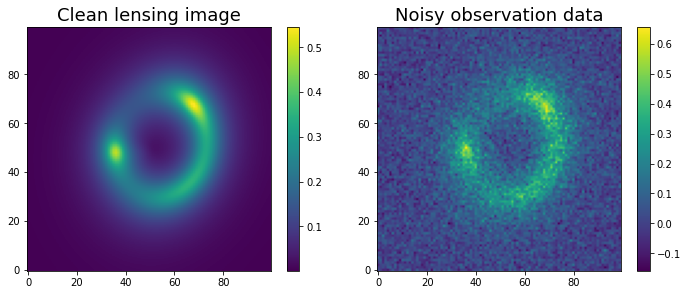

In [6]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
image_model = ImageModel(data_class=pixel_grid,
                         psf_class=psf,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         point_source_class=None,
                         kwargs_numerics=kwargs_numerics)

image = image_model.image(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light,
                          kwargs_ps={})

true_unlensed_source = image_model.source_surface_brightness(kwargs_source=kwargs_source_light, de_lensed=True)

# Noise
exp_time = 100
sigma_bkd = 0.05
poisson = image_util.add_poisson(image, exp_time)
gaussian = image_util.add_background(image, sigma_bkd)

# Observed noisy data
data = image + gaussian + poisson

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

In [7]:
# Run this cell twice for an accurate result. 
# The first time uses cached computation results, making it seem faster than it is.
%timeit image_model.image(kwargs_lens_mass, kwargs_source_light, kwargs_lens_light, kwargs_ps={})

The slowest run took 5.09 times longer than the fastest. This could mean that an intermediate result is being cached.
116 µs ± 96.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Source fitting

### Loss function

In [8]:
def create_loss_func(data, model, noise_var=None):
    """Create a jit-compiled callable loss function.
    
    Parameters
    ----------
    data : 2D array
        Observed image.
    model : instance of a jaxtronomy ImageModel
        ImageModel instance with a callable image() method.
    noise_var : 2D array, optional
        Noise variance per pixel assuming independence, i.e.
        a diagonal covariance matrix.
    
    """
    if noise_var is None:
        noise_var = jnp.ones_like(data)
    assert noise_var.shape == data.shape, "Invalid noise variance map"
        
    def loss_func(params):
        # Compute reconstruction with these parameters
        rec = model.image(kwargs_lens=params['kwargs_lens_mass'],
                          kwargs_source=params['kwargs_source_light'],
                          kwargs_lens_light=params['kwargs_lens_light'],
                          kwargs_ps={})
        
        # Chi-square
        loss = jnp.sum((data - rec)**2 / noise_var)

        # Regularisation
        # loss += ...
        
        return loss
    return jax.jit(loss_func)

# Create loss and grad(loss) functions of parameter dictionaries
noise_var = jnp.abs(image) / exp_time + gaussian.var()
loss = create_loss_func(data, image_model, noise_var)
grad_loss = jax.jit(jax.grad(loss))

Check loss and gradient of the true parameters.

In [9]:
p = {'kwargs_lens_mass': kwargs_lens_mass,
     'kwargs_source_light': kwargs_source_light,
     'kwargs_lens_light': kwargs_lens_light}

loss_true = loss(p)
print(f"loss: {loss_true:.2f}")
print(f"grad(loss): {grad_loss(p)}")

loss: 9959.64
grad(loss): {'kwargs_lens_light': [{}], 'kwargs_lens_mass': [{'center_x': DeviceArray(-184.12287419, dtype=float64), 'center_y': DeviceArray(64.97297538, dtype=float64), 'e1': DeviceArray(-411.38597311, dtype=float64), 'e2': DeviceArray(268.94365344, dtype=float64), 'theta_E': DeviceArray(59.19019431, dtype=float64)}, {'gamma1': DeviceArray(874.42605071, dtype=float64), 'gamma2': DeviceArray(-770.43622079, dtype=float64)}], 'kwargs_source_light': [{'R_sersic': DeviceArray(225.80069669, dtype=float64), 'amp': DeviceArray(25.03492597, dtype=float64), 'center_x': DeviceArray(-221.78841902, dtype=float64), 'center_y': DeviceArray(-100.32276241, dtype=float64), 'e1': DeviceArray(587.66610933, dtype=float64), 'e2': DeviceArray(-483.74275912, dtype=float64), 'n_sersic': DeviceArray(102.30698506, dtype=float64)}]}


### Minimize the loss function over source parameters using scipy
Since scipy.minimize() takes a 1D input array of parameters, we have to make the nested dictionary of params used by the loss function above compatible with this. The code below is rather clumsy and could certainly be generalised to allow the user to decide (i.e. switch on and off) which parameters to fix and which to include in the fit.

In [10]:
@jax.jit
def func(x):
    params = {'kwargs_lens_mass': kwargs_lens_mass,
              'kwargs_source_light': [{'amp': x[0], 'R_sersic': x[1], 'n_sersic': x[2], 'e1': x[3], 'e2': x[4],
                                       'center_x': x[5], 'center_y': x[6]}],
              'kwargs_lens_light': kwargs_lens_light}
    return loss(params)

@jax.jit
def grad_func(x):
    return jax.grad(func)(x)

@jax.jit
def hvp(x, v):
    return jax.grad(lambda x: jnp.vdot(grad_func(x), v))(x)

# Callback to track loss function in minimize()
class Metrics(object):
    def __init__(self):
        self.loss_history = []
        
    def __call__(self, x):
        self.loss_history.append(func(x))

def print_error(name, value, estimate):
    spaces = " " * (10 - len(name))
    if value != 0:
        error = 100 * abs(value - estimate) / value
        print(name + ":" + spaces + f"{error:.2f} %")
    else:
        error = abs(value - estimate)
        print(name + ":" + spaces + f"{error:.2f} (abs)")

### Method BFGS : gradient only

In [11]:
metrics = Metrics()
p_init = [1.0, 1.0, 1.0, 0.001, 0.001, 0.0, 0.0]  # kwargs_source_light
start_time = time()
opt = minimize(func, p_init, method='BFGS', jac=grad_func, callback=metrics)
print(opt)
print(f"Time: {time() - start_time : 0.2f} s")

      fun: 9953.647230088143
 hess_inv: array([[ 1.32318829e-01, -9.34652016e-03, -1.21012768e-02,
         3.73360325e-05,  9.23544198e-05,  2.37619790e-04,
         1.26318034e-04],
       [-9.34652016e-03,  7.83962029e-04,  8.13657040e-04,
        -5.77283883e-05,  1.54167762e-05, -1.56582589e-05,
        -4.10018797e-07],
       [-1.21012768e-02,  8.13657040e-04,  1.24025266e-03,
         2.65891268e-06, -6.58221244e-06, -1.58511523e-05,
        -1.59782982e-06],
       [ 3.73360325e-05, -5.77283883e-05,  2.65891269e-06,
         4.17365589e-05,  5.77067874e-07,  4.08790984e-06,
        -3.00341619e-06],
       [ 9.23544198e-05,  1.54167762e-05, -6.58221244e-06,
         5.77067874e-07,  4.07679787e-05,  3.75511026e-06,
         4.44594948e-06],
       [ 2.37619790e-04, -1.56582589e-05, -1.58511523e-05,
         4.08790984e-06,  3.75511026e-06,  8.95733607e-06,
         1.52285011e-06],
       [ 1.26318034e-04, -4.10018797e-07, -1.59782982e-06,
        -3.00341619e-06,  4.44594948e

In [12]:
p_final = {'kwargs_lens_mass': kwargs_lens_mass,
           'kwargs_source_light': [{'amp': opt.x[0], 'R_sersic': opt.x[1], 'n_sersic': opt.x[2], 
                                    'e1': opt.x[3], 'e2': opt.x[4],
                                    'center_x': opt.x[5], 'center_y': opt.x[6]}],
           'kwargs_lens_light': kwargs_lens_light}
rec_image = image_model.image(kwargs_lens=p_final['kwargs_lens_mass'],
                              kwargs_source=p_final['kwargs_source_light'],
                              kwargs_lens_light=p_final['kwargs_lens_light'],
                              kwargs_ps={})

rec_source = image_model.source_surface_brightness(kwargs_source=p_final['kwargs_source_light'], de_lensed=True)

Error
-----
amp:       1.96 %
R_sersic:  0.51 %
n_sersic:  1.53 %
e1:        -12.91 %
e2:        57.26 %
center_x:  0.26 %
center_y:  1.89 %


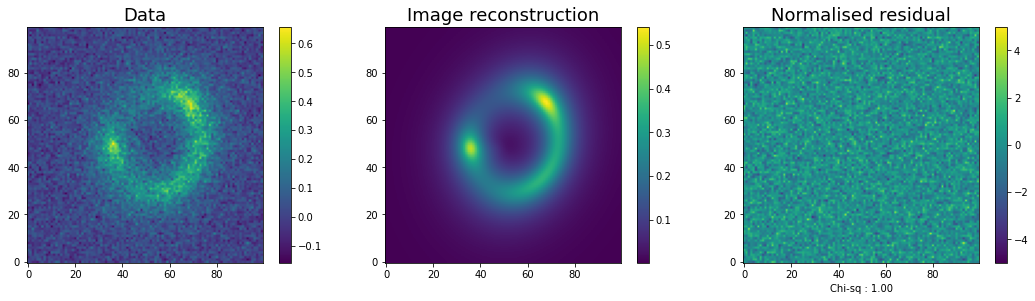

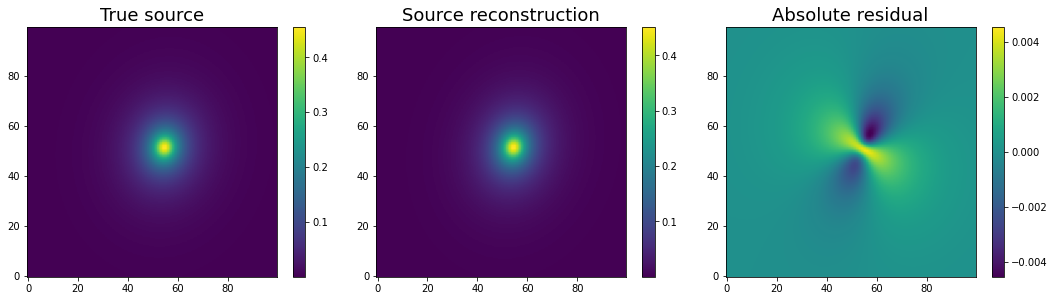

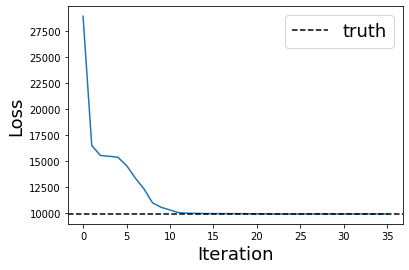

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(data, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(rec_image, origin='lower')
ax2.set_title("Image reconstruction", fontsize=FS)
img3 = ax3.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
ax3.set_title("Normalised residual", fontsize=FS)
ax3.set_xlabel(f"Chi-sq : {loss(p_final) / npix**2:.2f}")
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(true_unlensed_source, origin='lower')
ax1.set_title("True source", fontsize=FS)
img2 = ax2.imshow(rec_source, origin='lower')
ax2.set_title("Source reconstruction", fontsize=FS)
vmax = true_unlensed_source.max() / 100
img3 = ax3.imshow(true_unlensed_source - rec_source, origin='lower', vmin=-vmax, vmax=vmax)
ax3.set_title("Absolute residual", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(metrics.loss_history)), metrics.loss_history)
ax.axhline(y=loss_true, ls='--', c='k', label='truth')
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(fontsize=FS);

print("Error")
print("-----")
for i, params in enumerate(kwargs_source_light):
    for key, value in params.items():
        fit = p_final['kwargs_source_light'][i][key]
        print_error(key, value, fit)

### Method Newton-CG : gradient + Hessian vector product

In [14]:
metrics = Metrics()
p_init = [1.0, 1.0, 1.0, 0.001, 0.001, 0.0, 0.0]  # kwargs_source_light
start_time = time()
opt = minimize(func, p_init, method='Newton-CG', jac=grad_func, hessp=hvp, callback=metrics)
print(opt)
print(f"Time: {time() - start_time : 0.2f} s")

     fun: 9953.647243430283
     jac: array([-0.24198505, -2.1316092 , -0.9270193 , -2.79522397,  0.98205267,
        1.59890054,  0.86733664])
 message: 'Optimization terminated successfully.'
    nfev: 106
    nhev: 227
     nit: 65
    njev: 106
  status: 0
 success: True
       x: array([10.19517793,  1.2061502 ,  1.4771108 , -0.10160395,  0.04717234,
        0.40101216,  0.15283433])
Time:  21.19 s


In [15]:
p_final = {'kwargs_lens_mass': kwargs_lens_mass,
           'kwargs_source_light': [{'amp': opt.x[0], 'R_sersic': opt.x[1], 'n_sersic': opt.x[2], 
                                    'e1': opt.x[3], 'e2': opt.x[4],
                                    'center_x': opt.x[5], 'center_y': opt.x[6]}],
           'kwargs_lens_light': kwargs_lens_light}
rec_image = image_model.image(kwargs_lens=p_final['kwargs_lens_mass'],
                              kwargs_source=p_final['kwargs_source_light'],
                              kwargs_lens_light=p_final['kwargs_lens_light'],
                              kwargs_ps={})

rec_source = image_model.source_surface_brightness(kwargs_source=p_final['kwargs_source_light'], de_lensed=True)

Error
-----
amp:       1.95 %
R_sersic:  0.51 %
n_sersic:  1.53 %
e1:        -12.89 %
e2:        57.24 %
center_x:  0.25 %
center_y:  1.89 %


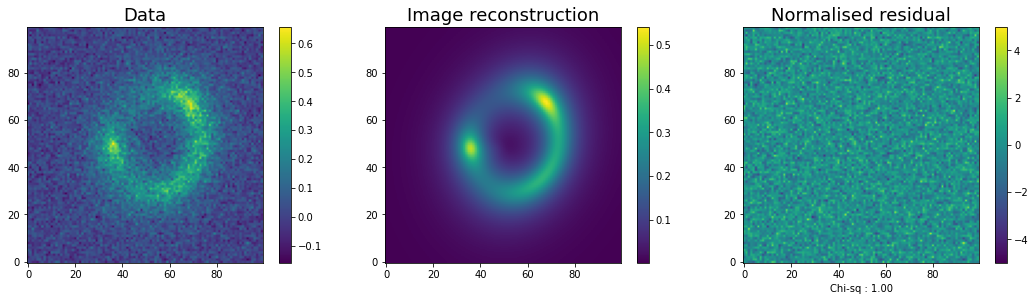

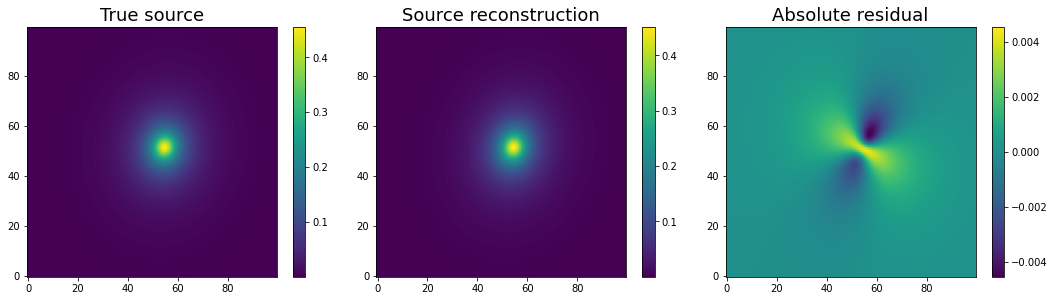

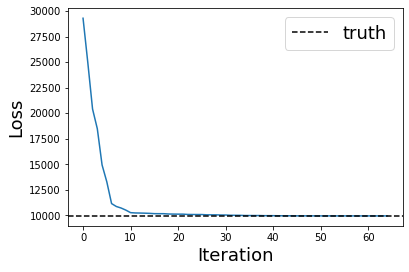

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(data, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(rec_image, origin='lower')
ax2.set_title("Image reconstruction", fontsize=FS)
img3 = ax3.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
ax3.set_title("Normalised residual", fontsize=FS)
ax3.set_xlabel(f"Chi-sq : {loss(p_final) / npix**2:.2f}")
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(true_unlensed_source, origin='lower')
ax1.set_title("True source", fontsize=FS)
img2 = ax2.imshow(rec_source, origin='lower')
ax2.set_title("Source reconstruction", fontsize=FS)
vmax = true_unlensed_source.max() / 100
img3 = ax3.imshow(true_unlensed_source - rec_source, origin='lower', vmin=-vmax, vmax=vmax)
ax3.set_title("Absolute residual", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(metrics.loss_history)), metrics.loss_history)
ax.axhline(y=loss_true, ls='--', c='k', label='truth')
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(fontsize=FS);

print("Error")
print("-----")
for i, params in enumerate(kwargs_source_light):
    for key, value in params.items():
        fit = p_final['kwargs_source_light'][i][key]
        print_error(key, value, fit)